In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
import pandas as pd
import numpy as np

# Load the thyroid dataset (ensure Thyroid.csv is in the same directory or provide the full path)
try:
    df = pd.read_csv('Thyroid.csv', header=0)  # Assuming your CSV has headers
    print(f"Dataset loaded successfully with shape: {df.shape}")
    print("First 5 rows of the dataset:\n", df.head())
except FileNotFoundError:
    print("Error: Thyroid.csv file not found. Please check the file path.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Creating synthetic data for demonstration purposes...")

    # Create synthetic data
    np.random.seed(42)
    n_samples = 1000
    n_features = 10
    
    # Generate synthetic data
    X = np.random.randn(n_samples, n_features)
    y = np.random.randint(0, 3, size=n_samples)  # 3 classes: normal, hyper, hypo

    # Feature names for demonstration
    feature_names = [f'feature_{i}' for i in range(n_features)]
    
    # Create dataframe
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y
    print(f"Created synthetic data with shape: {df.shape} for demonstration")


Dataset loaded successfully with shape: (9172, 31)
First 5 rows of the dataset:
    age sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick pregnant  \
0   29   F            f                  f                   f    f        f   
1   29   F            f                  f                   f    f        f   
2   41   F            f                  f                   f    f        f   
3   36   F            f                  f                   f    f        f   
4   32   F            f                  f                   f    f        f   

  thyroid_surgery I131_treatment query_hypothyroid  ...    TT4 T4U_measured  \
0               f              f                 t  ...    NaN            f   
1               f              f                 f  ...  128.0            f   
2               f              f                 f  ...    NaN            f   
3               f              f                 f  ...    NaN            f   
4               f              f           

In [4]:
# Display basic information about the dataset
print("\nDataset Information:")
df.info()

print("\nSample of the dataset:")
df.head()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych           

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [5]:
# Basic statistics
df.describe()


,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,9172.000000,8330.000000,6568.000000,8730.000000,8363.000000,8370.000000,349.000000,9.172000e+03
mean,73.555822,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057,8.529473e+08
std,1183.976718,24.184006,0.887579,37.522670,0.200360,41.551650,21.080504,7.581969e+06
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000,8.504090e+08
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000,8.510040e+08
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000,31.000000,8.607110e+08
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,8.701190e+08


In [6]:
# Handle missing values if any
print("\nMissing values in each column:")
print(df.isnull().sum())

# Fill missing values with median (for numeric) or mode (for categorical)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())


Missing values in each column:
age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64


In [7]:
# Define features and target variable
# Adjust this based on your actual dataset structure
try:
    X = df.drop('target', axis=1)
    y = df['target']
except KeyError:
    # If 'target' doesn't exist, assume the last column is the target
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    print("Assuming the last column is the target variable")

# Convert categorical features to numeric if needed
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.Categorical(X[col]).codes

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (9172, 30)
Target shape: (9172,)
Target distribution:
target
-      6771
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        85
GK       49
AK       46
J        30
B        21
MK       16
Q        14
O        14
C|I      12
KJ       11
GI       10
H|K       8
D         8
FK        6
C         6
P         5
MI        2
LJ        1
GKJ       1
OI        1
D|R       1
E         1
Name: count, dtype: int64


In [8]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter

# Check the original class distribution
print("Original class distribution:", Counter(y))

# Apply RandomOverSampler to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the new class distribution after applying oversampling
print("Resampled class distribution:", Counter(y_resampled))

# Split the data after oversampling
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Output the size of the new train/test splits
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")


Original class distribution: Counter({'-': 6771, 'K': 436, 'G': 359, 'I': 346, 'F': 233, 'R': 196, 'A': 147, 'L': 115, 'M': 111, 'N': 110, 'S': 85, 'GK': 49, 'AK': 46, 'J': 30, 'B': 21, 'MK': 16, 'Q': 14, 'O': 14, 'C|I': 12, 'KJ': 11, 'GI': 10, 'H|K': 8, 'D': 8, 'FK': 6, 'C': 6, 'P': 5, 'MI': 2, 'LJ': 1, 'GKJ': 1, 'OI': 1, 'D|R': 1, 'E': 1})
Resampled class distribution: Counter({'-': 6771, 'S': 6771, 'F': 6771, 'AK': 6771, 'R': 6771, 'I': 6771, 'M': 6771, 'N': 6771, 'G': 6771, 'K': 6771, 'A': 6771, 'KJ': 6771, 'L': 6771, 'MK': 6771, 'Q': 6771, 'J': 6771, 'C|I': 6771, 'O': 6771, 'LJ': 6771, 'H|K': 6771, 'D': 6771, 'GK': 6771, 'MI': 6771, 'P': 6771, 'FK': 6771, 'B': 6771, 'GI': 6771, 'C': 6771, 'GKJ': 6771, 'OI': 6771, 'D|R': 6771, 'E': 6771})
Training set size: (173337, 30), Testing set size: (43335, 30)


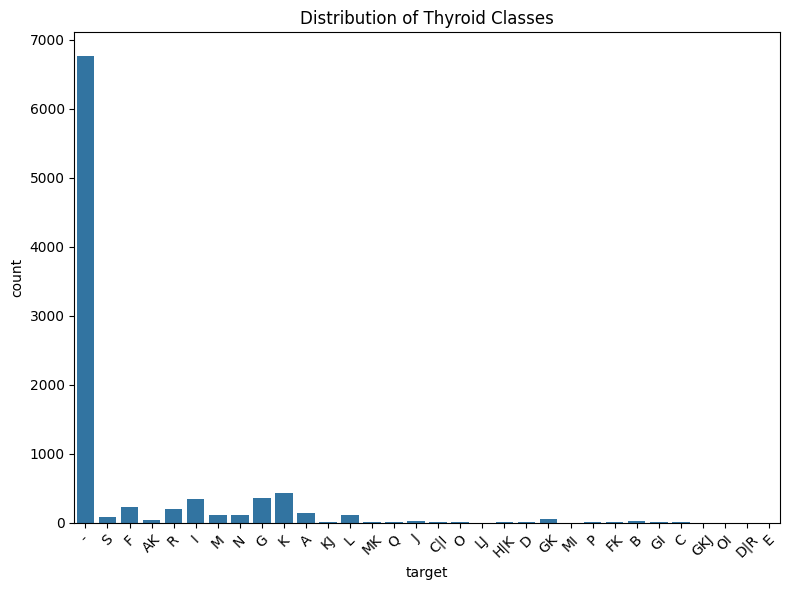

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Thyroid Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

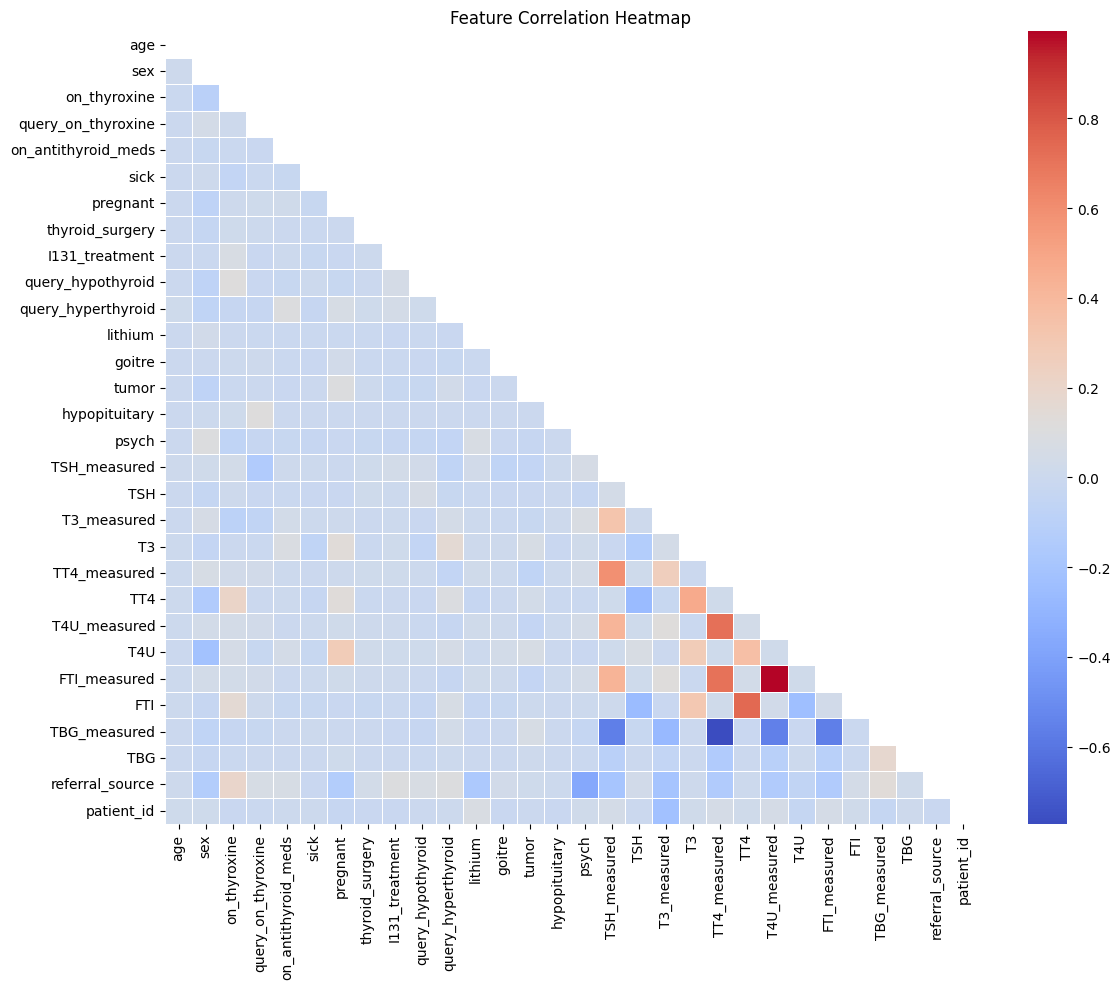

In [10]:
# Feature correlation heatmap
plt.figure(figsize=(12, 10))
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Define the 5 models that will be part of the ensemble
model1 = LogisticRegression(max_iter=1000, random_state=42)
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model3 = SVC(probability=True, random_state=42)
model4 = KNeighborsClassifier(n_neighbors=5)
model5 = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a dictionary of models
models = {
    'Logistic Regression': model1,
    'Random Forest': model2,
    'SVM': model3,
    'KNN': model4,
    'Gradient Boosting': model5
}

# Initialize a dictionary to store model performance
model_performance = {}


Training Logistic Regression...
  Train Accuracy: 0.9451
  Test Accuracy: 0.9444
  CV Accuracy: 0.9439 ± 0.0013

Classification Report:
              precision    recall  f1-score   support

           -       0.84      0.68      0.75      1354
           A       0.90      0.88      0.89      1354
          AK       0.86      0.97      0.91      1354
           B       0.92      1.00      0.96      1354
           C       0.99      1.00      1.00      1354
         C|I       1.00      1.00      1.00      1354
           D       1.00      1.00      1.00      1355
         D|R       1.00      1.00      1.00      1355
           E       1.00      1.00      1.00      1354
           F       0.95      0.88      0.92      1354
          FK       0.95      1.00      0.97      1355
           G       0.93      0.90      0.92      1354
          GI       0.94      1.00      0.97      1354
          GK       0.94      0.97      0.96      1354
         GKJ       0.99      1.00      0.99      135

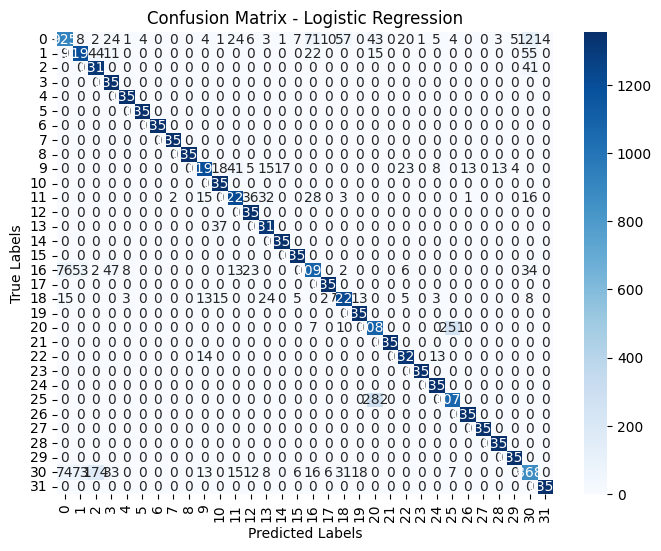


Training Random Forest...
  Train Accuracy: 1.0000
  Test Accuracy: 0.9991
  CV Accuracy: 0.9992 ± 0.0001

Classification Report:
              precision    recall  f1-score   support

           -       1.00      0.97      0.99      1354
           A       1.00      1.00      1.00      1354
          AK       1.00      1.00      1.00      1354
           B       1.00      1.00      1.00      1354
           C       1.00      1.00      1.00      1354
         C|I       1.00      1.00      1.00      1354
           D       1.00      1.00      1.00      1355
         D|R       1.00      1.00      1.00      1355
           E       1.00      1.00      1.00      1354
           F       1.00      1.00      1.00      1354
          FK       1.00      1.00      1.00      1355
           G       1.00      1.00      1.00      1354
          GI       1.00      1.00      1.00      1354
          GK       1.00      1.00      1.00      1354
         GKJ       1.00      1.00      1.00      1355
    

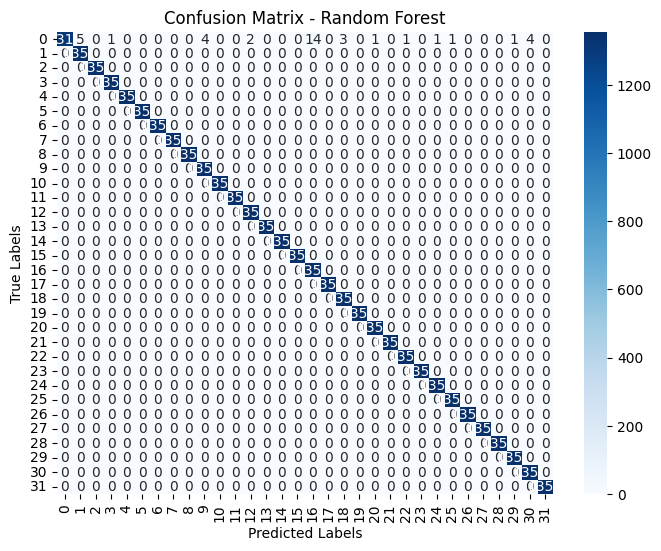


Training SVM...
  Train Accuracy: 0.9718
  Test Accuracy: 0.9711
  CV Accuracy: 0.9689 ± 0.0006

Classification Report:
              precision    recall  f1-score   support

           -       0.91      0.73      0.81      1354
           A       0.95      0.93      0.94      1354
          AK       0.92      1.00      0.96      1354
           B       0.98      1.00      0.99      1354
           C       1.00      1.00      1.00      1354
         C|I       1.00      1.00      1.00      1354
           D       1.00      1.00      1.00      1355
         D|R       1.00      1.00      1.00      1355
           E       1.00      1.00      1.00      1354
           F       0.99      0.96      0.97      1354
          FK       0.95      1.00      0.98      1355
           G       0.95      0.95      0.95      1354
          GI       0.98      1.00      0.99      1354
          GK       0.97      0.97      0.97      1354
         GKJ       0.99      1.00      1.00      1355
         H|K  

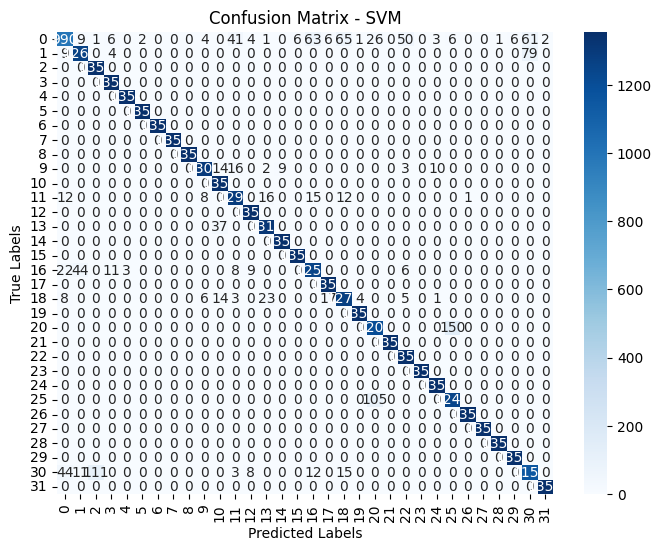


Training KNN...
  Train Accuracy: 0.9953
  Test Accuracy: 0.9936
  CV Accuracy: 0.9920 ± 0.0003

Classification Report:
              precision    recall  f1-score   support

           -       1.00      0.79      0.89      1354
           A       0.99      1.00      1.00      1354
          AK       1.00      1.00      1.00      1354
           B       1.00      1.00      1.00      1354
           C       1.00      1.00      1.00      1354
         C|I       1.00      1.00      1.00      1354
           D       1.00      1.00      1.00      1355
         D|R       1.00      1.00      1.00      1355
           E       1.00      1.00      1.00      1354
           F       1.00      1.00      1.00      1354
          FK       1.00      1.00      1.00      1355
           G       0.95      1.00      0.97      1354
          GI       1.00      1.00      1.00      1354
          GK       1.00      1.00      1.00      1354
         GKJ       1.00      1.00      1.00      1355
         H|K  

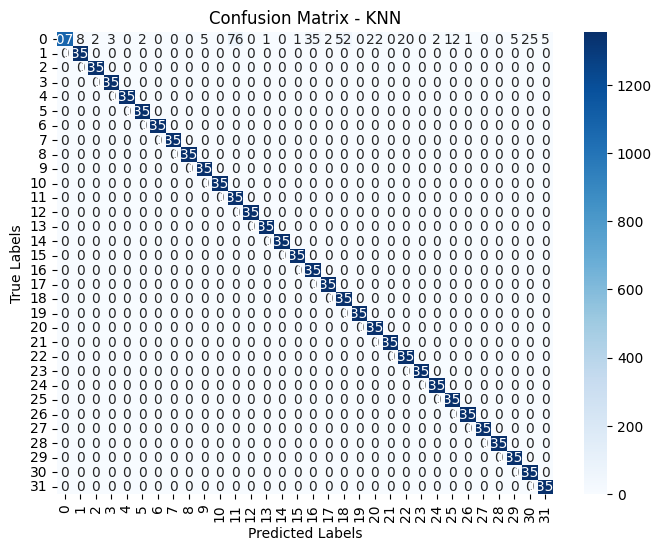


Training Gradient Boosting...


KeyboardInterrupt: 

In [13]:
# Train each model and evaluate its performance
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on training data
    train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, train_pred)
    
    # Evaluate on testing data
    test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    # Store the performance metrics
    model_performance[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }
    
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  CV Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [14]:
# Compare model performances
performance_df = pd.DataFrame({
    'Model': list(model_performance.keys()),
    'Training Accuracy': [model_performance[model]['train_accuracy'] for model in model_performance],
    'Testing Accuracy': [model_performance[model]['test_accuracy'] for model in model_performance],
    'CV Mean Accuracy': [model_performance[model]['cv_mean'] for model in model_performance],
    'CV Std': [model_performance[model]['cv_std'] for model in model_performance]
})
 
performance_df = performance_df.sort_values('Testing Accuracy', ascending=False).reset_index(drop=True)
performance_df

,Model,Training Accuracy,Testing Accuracy,CV Mean Accuracy,CV Std
0,Random Forest,1.000000,0.999123,0.999152,0.000138
1,KNN,0.995264,0.993562,0.992044,0.000282
2,SVM,0.971801,0.971063,0.968887,0.000599
3,Logistic Regression,0.945061,0.944364,0.943878,0.001263


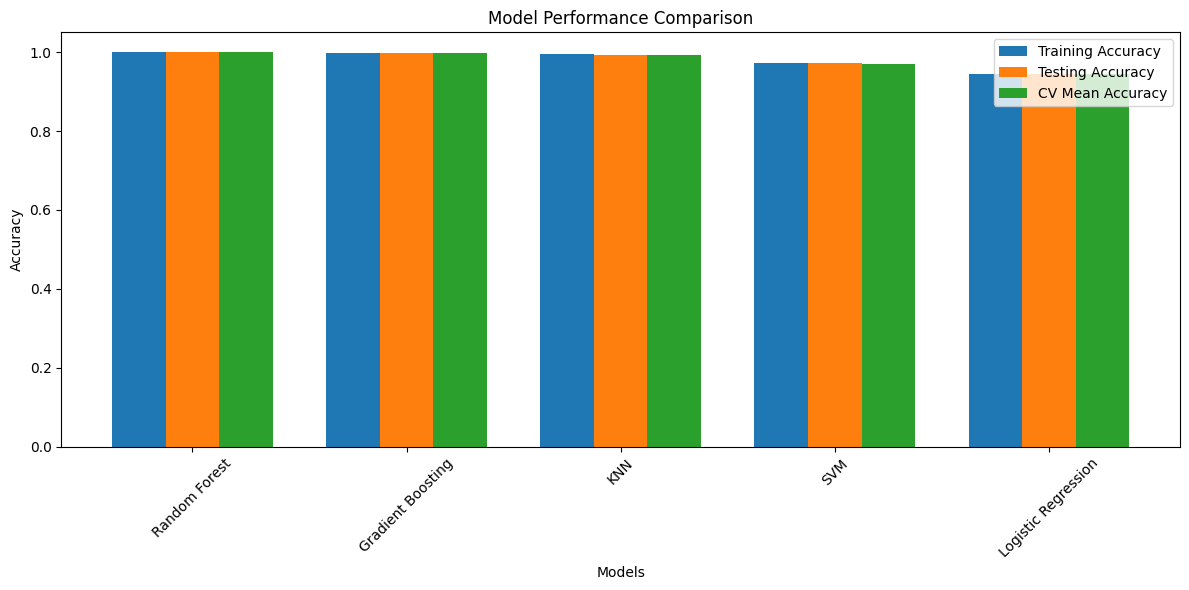

In [ ]:
# Visualize model performances
plt.figure(figsize=(12, 6))
x = np.arange(len(performance_df))
width = 0.25

plt.bar(x - width, performance_df['Training Accuracy'], width, label='Training Accuracy')
plt.bar(x, performance_df['Testing Accuracy'], width, label='Testing Accuracy')
plt.bar(x + width, performance_df['CV Mean Accuracy'], width, label='CV Mean Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, performance_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Classification report for the voting classifier
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting))

# Confusion matrix for the voting classifier
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classification Report for Voting Classifier:


NameError: name 'y_pred_voting' is not defined

In [ ]:
# Identify the best performing model (excluding the voting classifier)
best_model_name = performance_df[performance_df['Model'] != 'Voting Classifier'].iloc[0]['Model']
print(f"Best performing model: {best_model_name}")

# Define hyperparameter grids for the best model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Get the appropriate parameter grid
param_grid = param_grids.get(best_model_name, {})

if param_grid:
    print(f"Performing GridSearchCV on {best_model_name} with the following parameters:")
    print(param_grid)
    
    # Create a pipeline with preprocessing and the best model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', models[best_model_name])
    ])
    
    # Adjust parameter grid keys for pipeline
    pipeline_param_grid = {f'model__{key}': value for key, value in param_grid.items()}
    
    # Create the grid search
    grid_search = GridSearchCV(
        pipeline,
        pipeline_param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and score
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate the best model from grid search
    y_pred_best = grid_search.predict(X_test)
    best_accuracy = accuracy_score(y_test, y_pred_best)
    
    print(f"\nTuned {best_model_name} Accuracy: {best_accuracy:.4f}")
    
    # Compare with the original model
    print(f"Original {best_model_name} Accuracy: {performance_df[performance_df['Model'] == best_model_name]['Testing Accuracy'].values[0]:.4f}")
    
    # Add the tuned model to the performance comparison
    new_row = pd.DataFrame({
        'Model': [f'Tuned {best_model_name}'],
        'Training Accuracy': [accuracy_score(y_train, grid_search.predict(X_train))],
        'Testing Accuracy': [best_accuracy],
        'CV Mean Accuracy': [grid_search.best_score_],
        'CV Std': [0.0]  # We don't have the std directly from grid_search
    })
    
    performance_df = pd.concat([performance_df, new_row], ignore_index=True)
    performance_df = performance_df.sort_values('Testing Accuracy', ascending=False).reset_index(drop=True)
else:
    print(f"No parameter grid defined for {best_model_name}")

In [ ]:
# Final performance comparison
performance_df

In [ ]:
# Final visualization of model performances
plt.figure(figsize=(14, 8))
x = np.arange(len(performance_df))
width = 0.25

plt.bar(x - width, performance_df['Training Accuracy'], width, label='Training Accuracy')
plt.bar(x, performance_df['Testing Accuracy'], width, label='Testing Accuracy')
plt.bar(x + width, performance_df['CV Mean Accuracy'], width, label='CV Mean Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Final Model Performance Comparison')
plt.xticks(x, performance_df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Get the name of the best model from the final comparison
final_best_model_name = performance_df.iloc[0]['Model']
print(f"The best performing model is: {final_best_model_name}")

# Initialize the best model
from sklearn.externals import joblib
import pickle

# Save the appropriate model
if 'Tuned' in final_best_model_name:
    # Save the tuned model from grid search
    best_model = grid_search
    filename = 'best_tuned_thyroid_model.pkl'
elif final_best_model_name == 'Voting Classifier':
    # Save the voting classifier
    best_model = voting_clf
    filename = 'best_voting_thyroid_model.pkl'
else:
    # Save the original best model
    model_key = final_best_model_name
    best_model = models[model_key]
    filename = f'best_{model_key.lower().replace(" ", "_")}_thyroid_model.pkl'

# Save the model to a file
try:
    with open(filename, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Model saved as {filename}")
except Exception as e:
    print(f"Error saving model: {e}")
    print("Model not saved. This might be due to notebook environment restrictions.")